## Цель: 
**Провести анализ данных продаж компьютерных игр для выявления потенциально популярного продукта для планирования рекламы в зависимости от следующих показателей**
 - региона
 - игровой платформы
 - жанра
 - оценки пользователей
 - оценки экспертов
 - рейтинга

1. [Предобработка](#preprocessing)

**Шаг 1**

Откройте файл с данными и изучите общую информацию

- Загружаем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [9]:
from sklearn.cluster import KMeans

In [13]:
X = np.array([[-3, 3], [1, 4], [2, 6], [3, 8], [5, 2], [6, 11], [7, 1]])
kmean = KMeans(n_clusters=1).fit(X)
print(kmean.cluster_centers_)
print(kmean.inertia_)

[[3. 5.]]
146.0


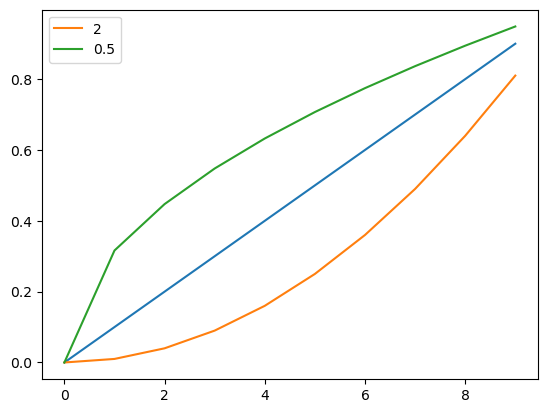

In [19]:
a = np.arange(0,1,0.1)
plt.plot(a)
plt.plot(a**2, label = '2')
plt.plot(a**0.5, label = '0.5')
#plt.plot(a+a +50, label = '1/a')
plt.legend()
plt.show()


In [105]:
# код ревьюера

try:
    df = pd.read_csv(r'C:\Users\takhi\Downloads\games.csv')
except FileNotFoundError as e:
    print(repr(e))
    df = pd.read_csv('/datasets/games.csv')
    
df.head()

FileNotFoundError(2, 'No such file or directory')


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [106]:
df.info() # оцениваем общую иноформацию по полученным данным

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


 _________________________________________________________________________________
 - в 6 столбцах из одиннадцати имеются пропуски данных
 - в столбце User_Score данные сохранены неверно, вместо float используется object
 - год выхода игры можно изменить на integer, но это не обязательно, так не влияете на дальнейши анализ
 _________________________________________________________________________________

In [107]:
df.describe()# оцениваем общие описательные статистики

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


 - Файл содержит инфомацию с 1980 по 2016 год
 - посмотрим какая информация содержится в столбцах с Именем, Платформой и Жанром, так как в последующем это потребуется для анализа

In [108]:
names = df.Name.nunique()
platforms = df.Platform.nunique()
genres = df.Genre.nunique()
print(f'names - {names},\ngenres - {genres},\nplatforms - {platforms}')


names - 11559,
genres - 12,
platforms - 31


<a id="preprocessing"> </a>
**Шаг 2** 

- Подготовьте данные
- Замените названия столбцов (приведите к нижнему регистру);
- Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;
- Обработайте пропуски при необходимости:
- Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
- Опишите причины, которые могли привести к пропускам;
- Обратите внимание на аббревиатуру 'tbd' в столбце с оценкой пользователей. Отдельно разберите это значение и опишите, как его обработать;
- Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [109]:
df = df.rename(columns=str.lower)# переведем названия стобцов в нижний регистр
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [110]:
df.isna().sum()# оценим количество пропусков по каждому из столбцов

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [111]:
df['user_score'].replace('tbd', np.nan, inplace=True)
# для получения возможности изменить тип данных на числовой заменим tab на nan

In [112]:
df[df['year_of_release'].isna()].isna().sum()
# там где нет данных по году выхода почти в половине случаев нет данных и по оценкам критиков, пользователей и рейтингу.
# в этой ситуции, учитывая небольшой объем пропусков, эти строки можно удалить

name                 0
platform             0
year_of_release    269
genre                0
na_sales             0
eu_sales             0
jp_sales             0
other_sales          0
critic_score       115
user_score         142
rating              88
dtype: int64

In [113]:
df.dropna(subset = ['year_of_release'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float64
 5   eu_sales         16446 non-null  float64
 6   jp_sales         16446 non-null  float64
 7   other_sales      16446 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       7463 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


In [114]:
#изменим тип данных в двух столбцах
df = df.astype({'year_of_release': 'int16','user_score' :'float32'}) 
df.dtypes

name                object
platform            object
year_of_release      int16
genre               object
na_sales           float64
eu_sales           float64
jp_sales           float64
other_sales        float64
critic_score       float64
user_score         float32
rating              object
dtype: object

In [115]:
# Код ревьюера

pd.Series([124], dtype='int8') + 20

0   -112
dtype: int8

**Как лучше обработать остальные пропуски примем решение после того, как оценим их распределение по годам**

In [116]:
total_count = df.groupby('year_of_release')['other_sales'].count()
pd.DataFrame(total_count).reset_index()
actual_data_count = df.groupby('year_of_release')[['critic_score', 'user_score','rating']].count().reset_index()

In [117]:
nan_analysis = pd.DataFrame(total_count).merge(actual_data_count, how='left',on='year_of_release')
nan_analysis.rename(columns={'other_sales':'reports_number'}, inplace=True)
nan_analysis['missid_critic_share'] = round( \
(nan_analysis['reports_number'] - nan_analysis['critic_score'])/nan_analysis['reports_number'],2)
nan_analysis['missid_users_share'] = round(\
(nan_analysis['reports_number'] - nan_analysis['user_score'])/nan_analysis['reports_number'],2)
nan_analysis['missid_rating_share'] = round( \
(nan_analysis['reports_number'] - nan_analysis['rating'])/nan_analysis['reports_number'],2)
nan_analysis[['year_of_release','missid_users_share','missid_critic_share','missid_rating_share']]

,year_of_release,missid_users_share,missid_critic_share,missid_rating_share
0,1980,1.00,1.00,1.00
1,1981,1.00,1.00,1.00
2,1982,1.00,1.00,1.00
3,1983,1.00,1.00,1.00
4,1984,1.00,1.00,1.00
5,1985,0.93,0.93,0.93
6,1986,1.00,1.00,1.00
7,1987,1.00,1.00,1.00
8,1988,0.93,0.93,0.93
9,1989,1.00,1.00,1.00


# До 2000 года отсутствует 90% и более данных в столбцах с оценками критиков, пользователей и рейтингу
- пока не будем заполнять эти пропуски,
- в дальнейшем анализе, где небходимы данные по оценкам и рейтингу, возможно, будем использовать только данные с 2000 года 

**Причины появления пропусков**
- до 1984 года по-видимому, вообще эти данные не собирались, так как они полностью отсутствуют. Далее они начали изредка появляться. С течением времени объем собираемых данных по отзывам и рейтингам становится больше. Но судя по всему эти разделы не являются обязательными при сборе статистики, поэтому даже в лучшие периоды могло отсутствовать до 21% этой информации. 

In [118]:
# код ревьюера

df.groupby('year_of_release').agg({'user_score' : lambda x : x.isna().mean()})

,user_score
year_of_release,
1980,1.000000
1981,1.000000
1982,1.000000
1983,1.000000
1984,1.000000
1985,0.928571
1986,1.000000
1987,1.000000
1988,0.933333


- Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.

In [119]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']
df.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24


**Шаг 3**

Проведите исследовательский анализ данных
- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам.
- За какой характерный срок появляются новые и исчезают старые платформы?
- Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
Не учитывайте в работе данные за предыдущие годы.
- Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
- Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.
- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
- Соотнесите выводы с продажами игр на других платформах.
- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

________________________________________________________________________________________
- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

In [120]:
games_by_year = df.pivot_table(index=['year_of_release'], values='name', aggfunc = 'count')#.sort_values(by ='name')
games_by_year['share_of_year'] = round(games_by_year['name'] / games_by_year['name'].sum(),4)
games_by_year

,name,share_of_year
year_of_release,,
1980,9,0.0005
1981,46,0.0028
1982,36,0.0022
1983,17,0.0010
1984,14,0.0009
1985,14,0.0009
1986,21,0.0013
1987,16,0.0010
1988,15,0.0009


**Вывод**
- до 1994 года количестов выпущенных игр очень мало по сравнению с другими периодами.
- Возможно, при дальнейшем анализе данные за этот период можно не рассматривать, учитывая,
что в эти же периоды нет данных по оценкам и рейтингу

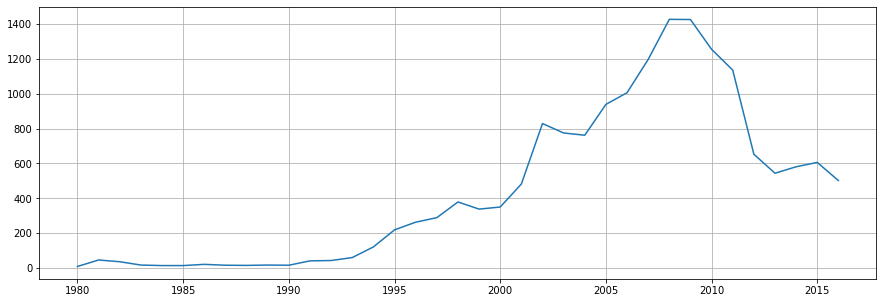

In [121]:
plt.figure(figsize=(15,5))
game_figure = games_by_year.reset_index()
plt.plot(game_figure['year_of_release'], game_figure['name'])
plt.grid()
plt.show();

_______________________________________________________________________________________________
- Посмотрите, как менялись продажи по платформам.

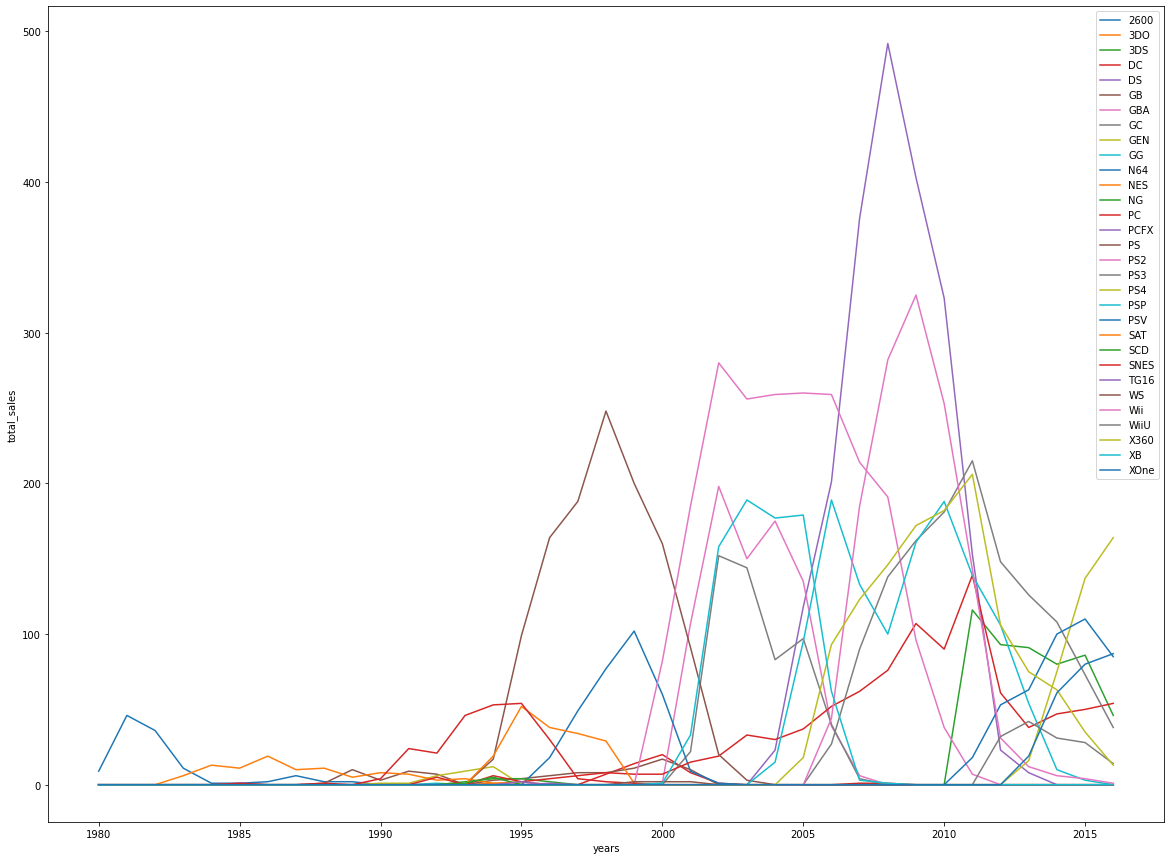

In [122]:
platform_sales = df.groupby(['year_of_release','platform'])['total_sales'].agg('count').unstack(level=-1).fillna(0).reset_index()
#platform_sales
plt.figure(figsize=(20,15))
platform = platform_sales.columns[1:]
for i in platform:
    plt.plot(platform_sales['year_of_release'],platform_sales[i], label=i)
plt.xlabel('years')
plt.ylabel('total_sales')
plt.legend()
plt.show()

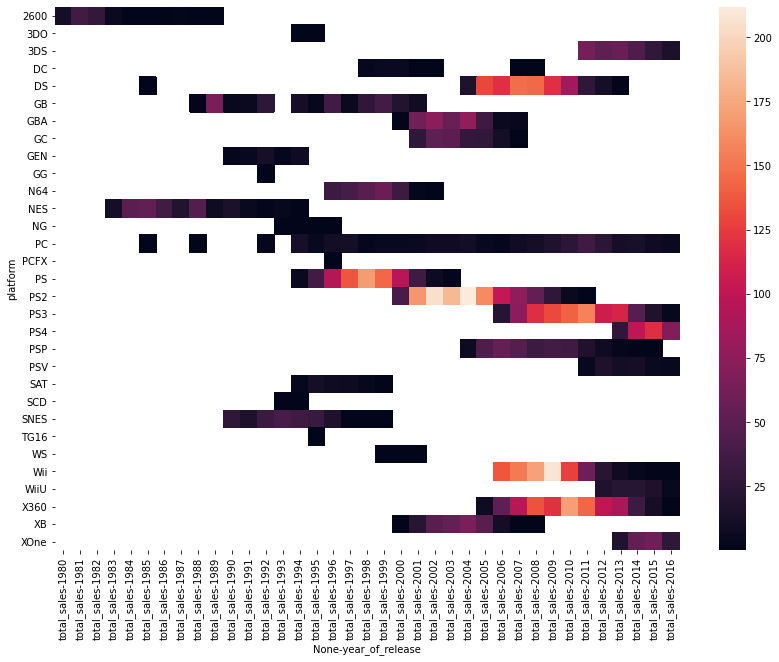

In [123]:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df.pivot_table(index=['year_of_release', 'platform'], values='total_sales', aggfunc= 'sum').unstack(level=0));

____________________________________________________________________________________________
- Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам.

In [124]:
top_ten = df.pivot_table(index='platform', values='total_sales', aggfunc='sum')\
.sort_values(by='total_sales', ascending=False)[:10].reset_index()
top_ten #платформы с наибольшими суммарными продажами

,platform,total_sales
0,PS2,1233.56
1,X360,961.24
2,PS3,931.34
3,Wii,891.18
4,DS,802.78
5,PS,727.58
6,PS4,314.14
7,GBA,312.88
8,PSP,289.53
9,3DS,257.81


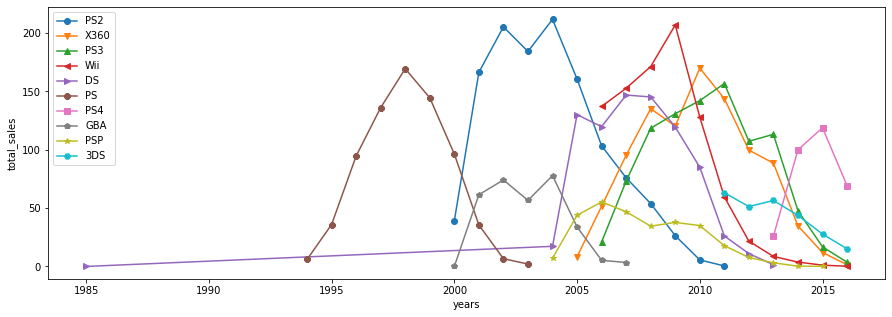

In [125]:
markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'H']
plt.figure(figsize=(15,5))
for i in range(10):
    platform = df[df['platform']==top_ten['platform'][i]].groupby('year_of_release')['total_sales'].sum().reset_index()
    x = platform['year_of_release'].values
    y = platform['total_sales'].values
    plt.plot(x,y, marker=markers[i], label=top_ten['platform'][i])
    plt.legend()
plt.xlabel('years')
plt.ylabel('total_sales')
plt.show();
#распределение по годам

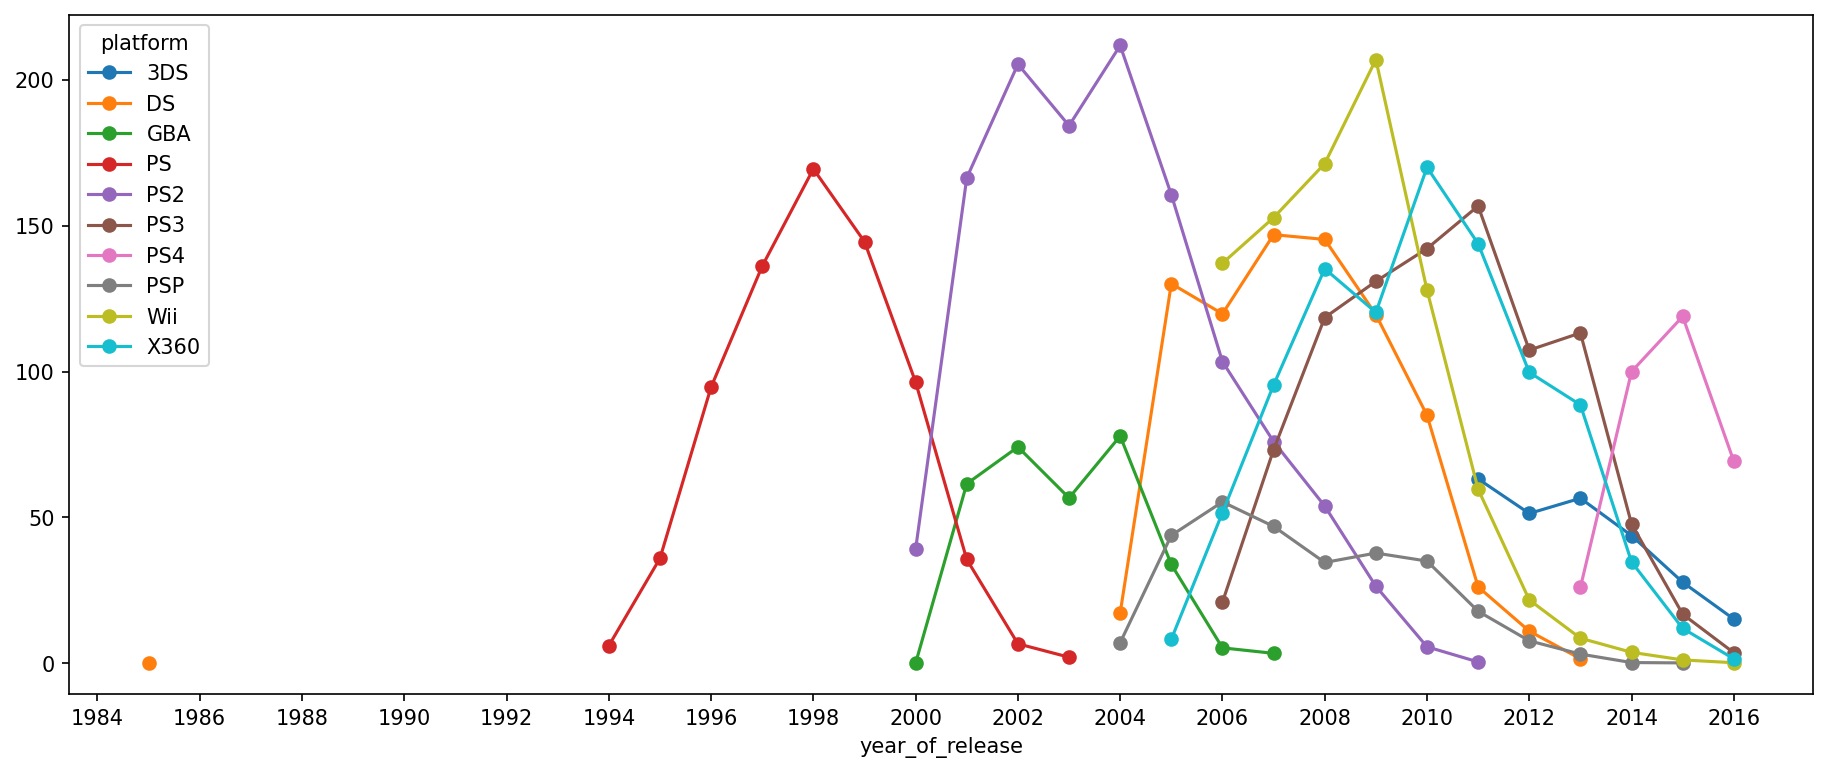

In [126]:
# Код ревьюера

import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(15,6), dpi=150)

df[df['platform'].isin(top_ten['platform'])].pivot_table(index='year_of_release',
                                                         columns='platform',
                                                         values='total_sales',
                                                         aggfunc='sum').plot(ax=ax, marker='o')

ax.xaxis.set_major_locator(ticker.MultipleLocator(2)) # это чтобы было видно каждый год

_____________________________________________________________________________
- За какой характерный срок появляются новые и исчезают старые платформы?

In [127]:
years = list(df.year_of_release.unique())
years.sort()

In [128]:
all_platforms = []
newcomers = {}
for i in range(1980, 2017):
    platforms = df[df['year_of_release'] ==i]['platform'].unique()
    for p in platforms:
        if p not in all_platforms:
            all_platforms.append(p)
            newcomers[i] = p
newcomers  #выведем годы, когда на рынок выходили новые платформы 

{1980: '2600',
 1983: 'NES',
 1985: 'DS',
 1988: 'GB',
 1990: 'GEN',
 1992: 'GG',
 1993: 'NG',
 1994: '3DO',
 1995: 'TG16',
 1996: 'PCFX',
 1998: 'DC',
 1999: 'WS',
 2000: 'GBA',
 2001: 'GC',
 2004: 'PSP',
 2005: 'X360',
 2006: 'PS3',
 2011: 'PSV',
 2012: 'WiiU',
 2013: 'XOne'}

In [129]:
a = list(newcomers.keys()) # периодичность появления новых платформ
new_platform_time = np.array(a)
print(f'средний срок появления новых платформ -  {round(np.diff(new_platform_time).mean(),2)} года,\n\
максимальный срок между появлением новых платформ -  {np.diff(new_platform_time).max()} лет,\n\
минимальнй срок между появлением новых платформ -  {np.diff(new_platform_time).min()} год')

средний срок появления новых платформ -  1.74 года,
максимальный срок между появлением новых платформ -  5 лет,
минимальнй срок между появлением новых платформ -  1 год


In [130]:
life_span = df.groupby(['platform','year_of_release'])['total_sales'].sum().reset_index()
platform_lifes = {}
for i in df['platform'].unique().tolist():
    platform_lifes[i] = life_span[life_span['platform'] == i] .shape[0]
platform_lifes

{'Wii': 11,
 'NES': 12,
 'GB': 13,
 'DS': 11,
 'X360': 12,
 'PS3': 11,
 'PS2': 12,
 'SNES': 10,
 'GBA': 8,
 'PS4': 4,
 '3DS': 6,
 'N64': 7,
 'PS': 10,
 'XB': 9,
 'PC': 26,
 '2600': 10,
 'PSP': 12,
 'XOne': 4,
 'WiiU': 5,
 'GC': 7,
 'GEN': 5,
 'DC': 7,
 'PSV': 6,
 'SAT': 6,
 'SCD': 2,
 'WS': 3,
 'NG': 4,
 'TG16': 1,
 '3DO': 2,
 'GG': 1,
 'PCFX': 1}

In [131]:
print(f'средний срок существования платформы - {round(np.mean(list(platform_lifes.values())),2)} лет\n\
максимальный срок существования платформы - {np.max(list(platform_lifes.values()))} лет\n\
минимальный срок существования платформы - {np.min(list(platform_lifes.values()))} год')

средний срок существования платформы - 7.68 лет
максимальный срок существования платформы - 26 лет
минимальный срок существования платформы - 1 год


___________________________________________________________________________________________________________________
- Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год. Не учитывайте в работе данные за предыдущие годы.
- Какие платформы лидируют по продажам, растут или падают?
_____________________________________________________________________________________________________________________

**Для построения прогоноза на 2017 год предлагаю использовать данные начиная с 2001 года потому что:**

    - начиная с этого периода у в таблице не так много пропусков по оценкам и рейтингу
    - этот период перекрывает средний срок существования платформы
    - данные по продажам будут тем актуальнее, чем ближе к прогнозируему периоду - поэтому для прогнозирования продаж можно взять ближайшие 5 лет.

**для прогнозирования оптимально сразу отобрать те платформы, которые имели продажи в последний отчетный период.**
- рассматаривать другие платформы для проноза не целесообразно,так как они уже прекратили существование. 

In [132]:
actual_platmorms = df[df['year_of_release'] == 2016]['platform'].unique().tolist()
actual_platmorms

['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'PC', 'X360', 'PSV', 'Wii']

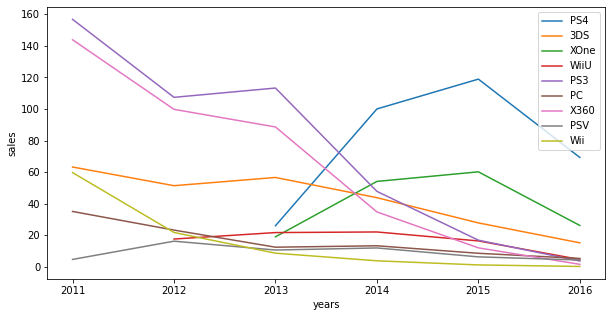

In [133]:
forecast_period = df[df['year_of_release'] > 2010].groupby(['year_of_release', 'platform'])['total_sales'].sum().reset_index()
plt.figure(figsize=(10,5))
for i in actual_platmorms:
    sales = forecast_period[forecast_period['platform']== i]
    x = sales['year_of_release'].values
    y = sales['total_sales'].values
    plt.plot(x,y, label = i)
plt.legend()
plt.xlabel('years')
plt.ylabel('sales')
plt.show();


**Промежуточный вывод**
- на последний отчетный период на рынке представлены девять платформ
- две появились три года назад
- в 2016 году ведущие 6 платоформы показали сильное снижение продаж
- лидерами остаются PS4, XOne,3DS

_________________________________________________________________________________________________________________
- Выберите несколько потенциально прибыльных платформ.
__________________________________________________________________________________________________________________

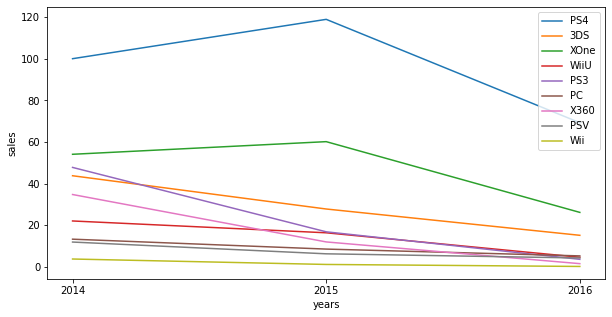

In [134]:
forecast_period_3 = df[df['year_of_release'] > 2013].groupby(['year_of_release', 'platform'])['total_sales'].sum().reset_index()
plt.figure(figsize=(10,5))
for i in actual_platmorms:
    sales = forecast_period_3[forecast_period_3['platform']== i]
    #x = sales['year_of_release'].values
    x = [2014,2015,2016]
    y = sales['total_sales'].values
    plt.plot(x,y, label = i)
plt.legend()
plt.xlabel('years')
plt.ylabel('sales')
plt.xticks([2014,2015,2016])
plt.show();

- динамика продаж действующих платформ за последние три года

In [135]:
sales_dynamic = df[df['year_of_release'] >2013].groupby(['year_of_release','platform'])['total_sales'].sum().unstack(level=0).reset_index()
sales_dynamic['2015/2014'] = sales_dynamic[2015] - sales_dynamic[2014]
sales_dynamic['2016/2015'] = sales_dynamic[2016] - sales_dynamic[2015]
sales_dynamic.drop(4,inplace = True)
sales_dynamic.loc[10,2014] = sales_dynamic[2014].sum()
sales_dynamic.loc[10,2015] = sales_dynamic[2015].sum()
sales_dynamic.loc[10,2016] = sales_dynamic[2016].sum()
sales_dynamic.loc[10,'platform'] = 'Sum_of_all_platforms'
sales_dynamic.sort_values(by=2016, ascending=False, ignore_index=True, inplace=True)
sales_dynamic

year_of_release,platform,2014,2015,2016,2015/2014,2016/2015
0,Sum_of_all_platforms,331.29,267.86,129.94,NaN,NaN
1,PS4,100.00,118.90,69.25,18.90,-49.65
2,XOne,54.07,60.14,26.15,6.07,-33.99
3,3DS,43.76,27.78,15.14,-15.98,-12.64
4,PC,13.28,8.52,5.25,-4.76,-3.27
5,WiiU,22.03,16.35,4.60,-5.68,-11.75
6,PSV,11.90,6.25,4.25,-5.65,-2.00
7,PS3,47.76,16.82,3.60,-30.94,-13.22
8,X360,34.74,11.96,1.52,-22.78,-10.44
9,Wii,3.75,1.14,0.18,-2.61,-0.96


In [136]:
# Код ревьюера

df[df['year_of_release'] >2013] \
    .groupby(['platform','year_of_release']) \
    .agg({'total_sales' : 'sum'}) \
    .rolling(window=2) \
    .apply(lambda x : x[1] - x[0])

total_sales
platform year_of_release             
3DS      2014                     NaN
         2015                  -15.98
         2016                  -12.64
PC       2014                   -1.86
         2015                   -4.76
         2016                   -3.27
PS3      2014                   42.51
         2015                  -30.94
         2016                  -13.22
PS4      2014                   96.40
         2015                   18.90
         2016                  -49.65
PSP      2014                  -69.01
         2015                   -0.12
PSV      2014                   11.78
         2015                   -5.65
         2016                   -2.00
Wii      2014                   -0.50
         2015                   -2.61
         2016                   -0.96
WiiU     2014                   21.85
         2015                   -5.68
         2016                  -11.75
X360     2014                   30.14
         2015                  -22.78
         2016                  -10.44
XOne     2014                   52.55
         2015                    6.07
         2016                  -33.99

- все платформы снизили продажи в 2016 году
- можно ожидать,что в 2017 году с рынка уйдут две или даже три последнии платформы: Wii, X360, PS3
- для задачи прогнозирования можно предположить, что первые три платформы останутся потенциально прибыльными: PS4, XOne, 3DS

______________________________________________________________________________________________________________
- Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.

_____________________________________________________________________________________________________________

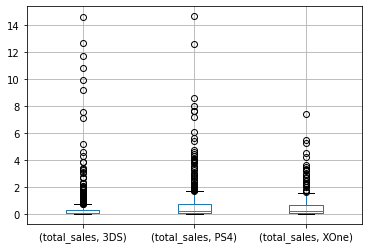

In [137]:
boxplots = df[(df['platform'] == 'PS4') | (df['platform'] == 'XOne') | (df['platform'] == '3DS')].\
pivot_table(index=['name','platform'], values = 'total_sales', aggfunc='sum').unstack(level=-1).reset_index()
boxplots.boxplot(column=[('total_sales',  '3DS'),
            ('total_sales',  'PS4'),
            ('total_sales', 'XOne')])
plt.show()

<AxesSubplot:title={'center':'total_sales'}, xlabel='platform'>

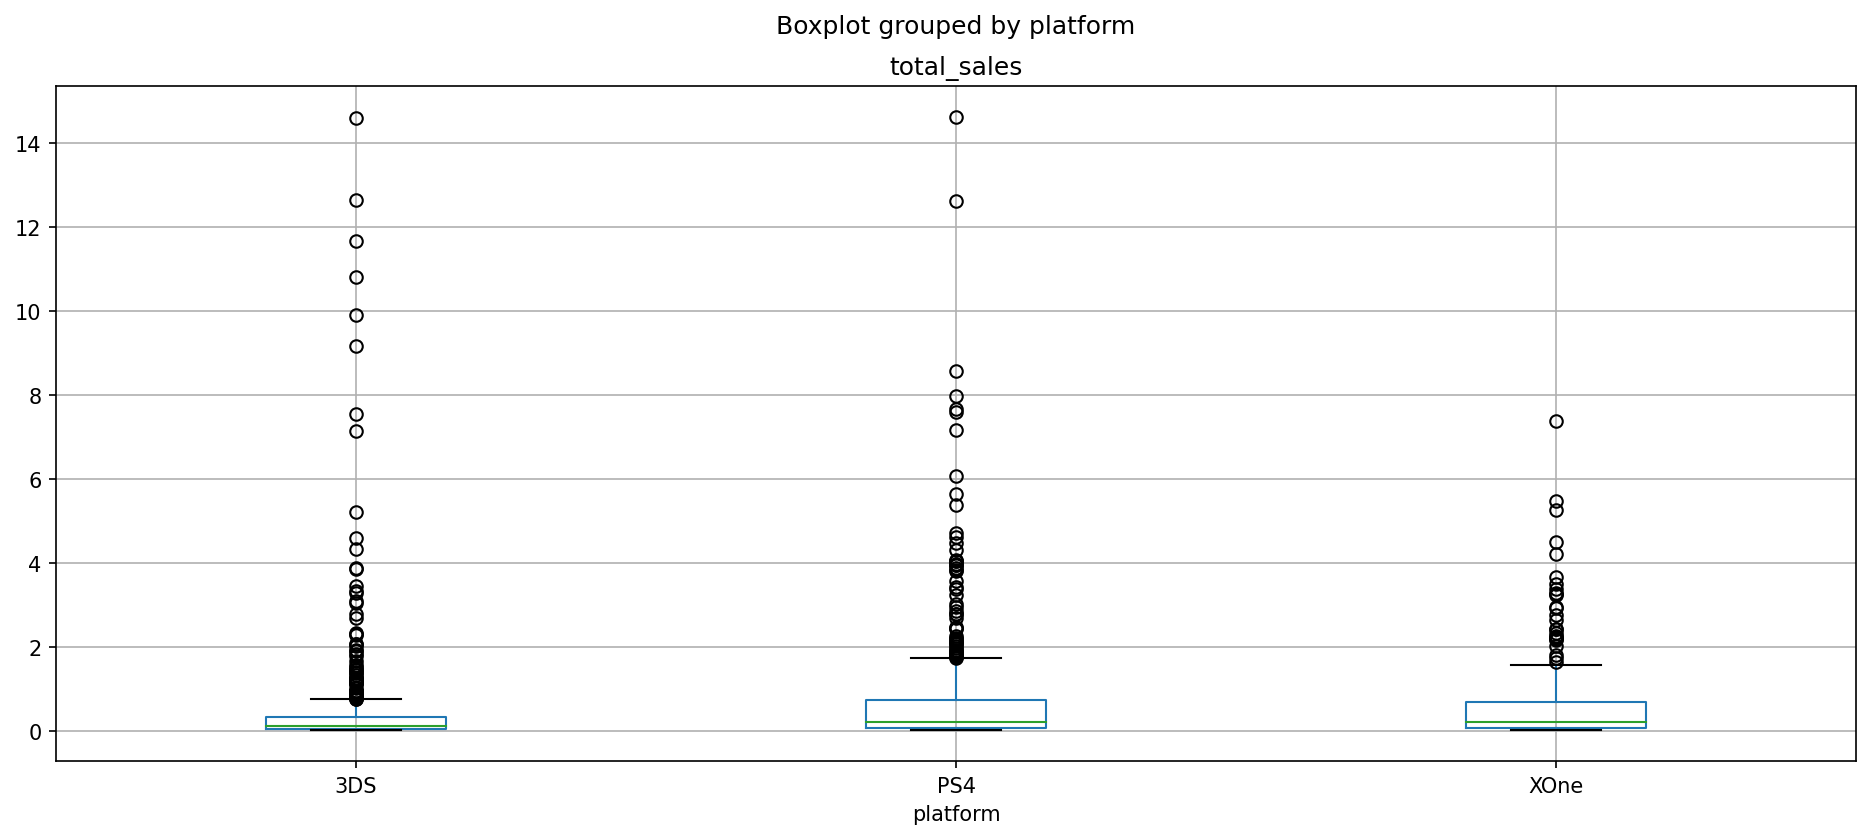

In [138]:
# Код ревьюера

fig, ax = plt.subplots(figsize=(15,6), dpi=150)

df[df['platform'].isin(['PS4','XOne','3DS'])].boxplot(by='platform', column='total_sales', ax=ax)

 - три лидирующие платформы имеют примерно одинаковый уровень средних продаж на игру, чуть ниже у 3DS
 - у платформы 3DS самый большой разброс продаж, у ней есть игры, которые являются лидерами по объему продаж среди этих платфрм
 - самый маленький разброс продаж по играм у платформы XOne

- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

 **для выбора оптимального метода оценки корреляции оценим для каждого из параметров нормальность распределения**

In [144]:
sales_critics = df[df['platform'] == 'PS4']
# выберем данные только по одной платформе для анализа и только за последние три года
sales_critics = sales_critics[sales_critics['year_of_release'] > 2013]
sales_critics = sales_critics.iloc[:,8:12]
sales_critics

,critic_score,user_score,rating,total_sales
31,NaN,NaN,NaN,14.63
42,97.0,8.3,M,12.62
77,82.0,4.3,E,8.58
87,NaN,NaN,NaN,7.98
92,83.0,5.7,M,7.66
...,...,...,...,...
16500,69.0,7.5,NaN,0.01
16503,NaN,NaN,NaN,0.01
16526,61.0,7.9,T,0.01
16530,51.0,5.5,M,0.01


In [85]:
# Код ревьюера

df.loc[df['platform'] == 'PS4','critic_score' : 'total_sales']

,critic_score,user_score,rating,total_sales
31,NaN,NaN,NaN,14.63
42,97.0,8.3,M,12.62
77,82.0,4.3,E,8.58
87,NaN,NaN,NaN,7.98
92,83.0,5.7,M,7.66
...,...,...,...,...
16500,69.0,7.5,NaN,0.01
16503,NaN,NaN,NaN,0.01
16526,61.0,7.9,T,0.01
16530,51.0,5.5,M,0.01


In [145]:
critics_corr = sales_critics[sales_critics['critic_score'].notna()].loc[:, ['critic_score','total_sales']]
k2,p = st.normaltest(critics_corr.critic_score.values)
if p < 0.001:
    print('Normal')
else:
    print('Not normal')
# для оценки критиков
critics_corr.corr()

Normal


,critic_score,total_sales
critic_score,1.000000,0.402661
total_sales,0.402661,1.000000


In [146]:
users_corr = sales_critics[sales_critics['user_score'].notna()].loc[:, ['user_score','total_sales']]
k2,p = st.normaltest(users_corr.user_score.values)
if p < 0.001:
    print('Normal')
else:
    print('Not normal')
# для оценки пользователей
users_corr.corr()

Normal


,user_score,total_sales
user_score,1.000000,-0.040132
total_sales,-0.040132,1.000000


**Если использовать оценку корреляции методом Пирсона то:**

- есть положительная средняя корреляция между уровнем продаж и оценкой критиков
- практически нет корреляции между продажами и оценкой пользователей, она отрицательна с очень низким уровнем

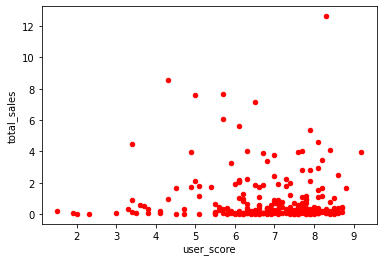

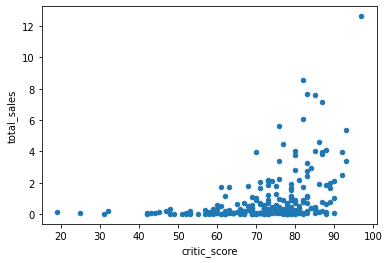

In [147]:
sales_critics.plot.scatter(x='user_score', y='total_sales', c='red')
sales_critics.plot.scatter(x='critic_score', y='total_sales')
plt.show()

**Промежуточный вывод**

расчетная и визуальная оценка коррелляции между уровнем продаж и оценкой пользователей и оценкой критиков совпадают
- есть положительная корреляция с оценкой критиков
- не значимая отрицательная корреляция с оценкой пользователей

_____________________________________________________________
- Соотнесите выводы с продажами игр на других платформах.
__________________________________________________

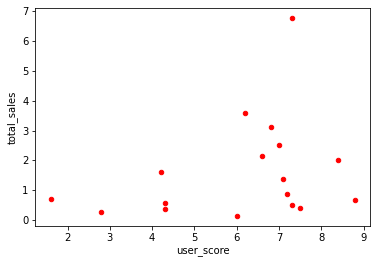

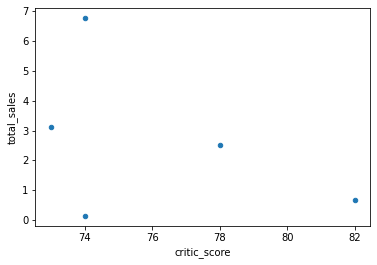

In [163]:
# проведем аналогичный анализ для другой популярной платформы
sales_critics2 = df[(df['platform'] == 'Wii')] # выберем данные только по другой платформе для анализа
sales_critics2 = sales_critics2[sales_critics2['year_of_release'] > 2011]
sales_critics2 = sales_critics2.iloc[:,8:12]
sales_critics2.plot.scatter(x='user_score', y='total_sales', c='red')
sales_critics2.plot.scatter(x='critic_score', y='total_sales')
plt.show()
# здесь данных за последние три года очень мало, для анализа недостаточно, поэтому для оценки корреляции взял перид больше

In [174]:
wii = sales_critics2[sales_critics2.user_score.notna()] #корреляция с оценкой пользователей
wii.loc [:,['user_score', 'total_sales']].corr().round(3)

,user_score,total_sales
user_score,1.000,0.296
total_sales,0.296,1.000


In [172]:
wii = sales_critics2[sales_critics2.user_score.notna()]#корреляция с оценкой критиков
wii.loc [:,['critic_score', 'total_sales']].corr().round(2)

,critic_score,total_sales
critic_score,1.00,-0.42
total_sales,-0.42,1.00


In [171]:
xone = df[df.platform=='XOne'] # для платформы XOne корреляция с оценкой пользователей
xone = xone[xone['year_of_release'] > 2013]
xone = xone[xone['user_score'].notna()]
xone.loc[:,['user_score', 'total_sales']].corr().round(2)

,user_score,total_sales
user_score,1.00,-0.07
total_sales,-0.07,1.00


In [170]:
xone = xone[xone['critic_score'].notna()] #корреляция с оценкой критиков
xone.loc[:,['critic_score', 'total_sales']].corr().round(2)

,critic_score,total_sales
critic_score,1.00,0.42
total_sales,0.42,1.00


**Промежуточный вывод**
- при анализе ещё двух платформ можно отметить, что оценка критиков имеет более сильную положительную корреяцию с уровнем продаж
- корреляция с оценкой пользователей значительно меньше

 _____________________________________________________
 - Посмотрите на общее распределение игр по жанрам.
 - Что можно сказать о самых прибыльных жанрах?
 - Выделяются ли жанры с высокими и низкими продажами?
 ___________

In [176]:
genres = df[df['year_of_release'] > 2013].groupby('genre').agg({'genre':'count','total_sales':'sum'})
genres['sales_share'] = round(genres['total_sales'] / genres['total_sales'].sum(),2)
genres['genre_share'] = round(genres['genre'] / genres['genre'].sum(),2)
genres['sales_per_one_name'] = round(genres['total_sales'] / genres['genre'],3)
genres.sort_values(by='sales_share', ascending=False)
# Исправил на последние три года!

,genre,total_sales,sales_share,genre_share,sales_per_one_name
genre,,,,,
Action,619,199.36,0.27,0.37,0.322
Shooter,128,170.94,0.23,0.08,1.335
Sports,161,109.48,0.15,0.10,0.680
Role-Playing,221,101.44,0.14,0.13,0.459
Misc,113,37.55,0.05,0.07,0.332
Fighting,60,28.22,0.04,0.04,0.470
Racing,69,27.52,0.04,0.04,0.399
Adventure,185,17.55,0.02,0.11,0.095
Platform,38,18.09,0.02,0.02,0.476


**Промежуточный вывод**
- оценить прибыльность жанров по имеющимся данным можно только, если продажи считать за прибыль, но это всегда объективно
- можно в качестве прибыльности взять продажи на одну игру в рамках жанра
- по уровню продажи лидерами являются жанры с Action, Sports, Shooter
- отстающие жанры Strategy, Pazzle, Adventure

**Шаг 4**

Составьте портрет пользователя каждого региона

Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [39]:
df.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24


In [179]:
users_platforms = df[df['year_of_release'] >2013].groupby('platform')[['na_sales','eu_sales','jp_sales','other_sales']].agg('sum').reset_index()
users_platforms.head()

,platform,na_sales,eu_sales,jp_sales,other_sales
0,3DS,22.64,16.12,44.24,3.68
1,PC,7.23,17.97,0.00,1.85
2,PS3,22.05,25.54,11.22,9.37
3,PS4,98.61,130.04,15.02,44.48
4,PSP,0.00,0.00,0.36,0.00


In [180]:
# посмотрим как пользователи из разных регионов отличаются по использованию разных платформ
users_platforms.loc[31,'platform'] = 'total_sales'
users_platforms.loc[31,'na_sales'] = users_platforms['na_sales'].sum()
users_platforms.loc[31,'eu_sales'] = users_platforms['eu_sales'].sum()
users_platforms.loc[31,'jp_sales'] = users_platforms['jp_sales'].sum()
users_platforms.loc[31,'other_sales'] = users_platforms['other_sales'].sum() 
users_platforms

,platform,na_sales,eu_sales,jp_sales,other_sales
0,3DS,22.64,16.12,44.24,3.68
1,PC,7.23,17.97,0.00,1.85
2,PS3,22.05,25.54,11.22,9.37
3,PS4,98.61,130.04,15.02,44.48
4,PSP,0.00,0.00,0.36,0.00
5,PSV,2.52,3.53,14.54,1.81
6,Wii,2.08,2.59,0.00,0.40
7,WiiU,19.36,13.15,7.31,3.16
8,X360,28.30,15.49,0.08,4.35
9,XOne,81.27,46.25,0.32,12.52


In [181]:
# посмотирим какие рейтинги платформ по регионам
na = users_platforms.sort_values(by='na_sales', ascending=False, ignore_index=True)[['platform', 'na_sales']][:10]
na

,platform,na_sales
0,total_sales,284.06
1,PS4,98.61
2,XOne,81.27
3,X360,28.30
4,3DS,22.64
5,PS3,22.05
6,WiiU,19.36
7,PC,7.23
8,PSV,2.52
9,Wii,2.08


In [182]:
eu = users_platforms.sort_values(by='eu_sales', ascending=False, ignore_index=True)[['platform', 'eu_sales']][:10]
eu

,platform,eu_sales
0,total_sales,270.68
1,PS4,130.04
2,XOne,46.25
3,PS3,25.54
4,PC,17.97
5,3DS,16.12
6,X360,15.49
7,WiiU,13.15
8,PSV,3.53
9,Wii,2.59


In [183]:
jp = users_platforms.sort_values(by='jp_sales', ascending=False, ignore_index=True)[['platform', 'jp_sales']][:10]
jp

,platform,jp_sales
0,total_sales,93.09
1,3DS,44.24
2,PS4,15.02
3,PSV,14.54
4,PS3,11.22
5,WiiU,7.31
6,PSP,0.36
7,XOne,0.32
8,X360,0.08
9,PC,0.00


In [184]:
os = users_platforms.sort_values(by='other_sales', ascending=False, ignore_index=True)[['platform', 'other_sales']][:10]
os

,platform,other_sales
0,total_sales,81.62
1,PS4,44.48
2,XOne,12.52
3,PS3,9.37
4,X360,4.35
5,3DS,3.68
6,WiiU,3.16
7,PC,1.85
8,PSV,1.81
9,Wii,0.40


In [185]:
# общий рейтинг топ 5 платформ по регионам
global_rating = na.merge(eu, left_index=True, right_index=True, suffixes=('_na', '_eu')).\
merge(jp,left_index=True, right_index=True, suffixes=('_jp', '_jp')).merge(os,left_index=True, \
                                                    right_index=True,suffixes=('_jp', '_os'))
global_rating[:6]

,platform_na,na_sales,platform_eu,eu_sales,platform_jp,jp_sales,platform_os,other_sales
0,total_sales,284.06,total_sales,270.68,total_sales,93.09,total_sales,81.62
1,PS4,98.61,PS4,130.04,3DS,44.24,PS4,44.48
2,XOne,81.27,XOne,46.25,PS4,15.02,XOne,12.52
3,X360,28.30,PS3,25.54,PSV,14.54,PS3,9.37
4,3DS,22.64,PC,17.97,PS3,11.22,X360,4.35
5,PS3,22.05,3DS,16.12,WiiU,7.31,3DS,3.68


- по предпочтениям платформ сильно отличается японский потребитель
- в остальных регионах в топ 5 входят четыре одинаковые платформы: PS2, PS3, X360, Wii

In [190]:
from IPython.display import display, HTML

CSS = """
.output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))
display(na)
display(eu)
display(jp)
display(os)

,platform,na_sales
0,total_sales,284.06
1,PS4,98.61
2,XOne,81.27
3,X360,28.30
4,3DS,22.64
5,PS3,22.05
6,WiiU,19.36
7,PC,7.23
8,PSV,2.52
9,Wii,2.08


,platform,eu_sales
0,total_sales,270.68
1,PS4,130.04
2,XOne,46.25
3,PS3,25.54
4,PC,17.97
5,3DS,16.12
6,X360,15.49
7,WiiU,13.15
8,PSV,3.53
9,Wii,2.59


,platform,jp_sales
0,total_sales,93.09
1,3DS,44.24
2,PS4,15.02
3,PSV,14.54
4,PS3,11.22
5,WiiU,7.31
6,PSP,0.36
7,XOne,0.32
8,X360,0.08
9,PC,0.00


,platform,other_sales
0,total_sales,81.62
1,PS4,44.48
2,XOne,12.52
3,PS3,9.37
4,X360,4.35
5,3DS,3.68
6,WiiU,3.16
7,PC,1.85
8,PSV,1.81
9,Wii,0.40


In [194]:
from IPython.display import display_html 
display_html(na._repr_html_()+eu._repr_html_(), raw=True)

,platform,na_sales
0,total_sales,284.06
1,PS4,98.61
2,XOne,81.27
3,X360,28.30
4,3DS,22.64
5,PS3,22.05
6,WiiU,19.36
7,PC,7.23
8,PSV,2.52
9,Wii,2.08


In [196]:
# посмотрим какие жанры наиболее популярны в регионах
genres = df[df['year_of_release'] > 2013]  .groupby('genre')[['genre','na_sales','eu_sales','jp_sales','other_sales']].sum().reset_index()

In [197]:
na_g = genres.loc[:, ['genre','na_sales']].sort_values(by='na_sales',ignore_index=True, ascending=False)
eu_g = genres.loc[:, ['genre','eu_sales']].sort_values(by='eu_sales',ignore_index=True, ascending=False)
jp_g = genres.loc[:, ['genre','jp_sales']].sort_values(by='jp_sales',ignore_index=True, ascending=False)
os_g = genres.loc[:, ['genre','other_sales']].sort_values(by='other_sales',ignore_index=True, ascending=False)


In [198]:
genres_rating = na_g.merge(eu_g, left_index=True, right_index=True, suffixes = ('_na', '_eu')).\
merge(jp_g, left_index=True, right_index=True, suffixes = ('_jp', '_jp')).\
merge(os_g, left_index=True, right_index=True, suffixes = ('_jp', '_os'))
genres_rating[:5]

,genre_na,na_sales,genre_eu,eu_sales,genre_jp,jp_sales,genre_os,other_sales
0,Shooter,79.02,Action,74.68,Role-Playing,31.16,Action,22.57
1,Action,72.53,Shooter,65.52,Action,29.58,Shooter,21.53
2,Sports,46.13,Sports,45.73,Fighting,6.37,Sports,14.36
3,Role-Playing,33.47,Role-Playing,28.17,Misc,5.61,Role-Playing,8.64
4,Misc,15.05,Racing,14.13,Shooter,4.87,Misc,4.03


- по предпочитаемым жанрам во всех в тройку лидеров входят три жанра: Action, Sports, Misc
- три региона, кроме Японии имеют очень схожие предпочтения и одинаковый топ-3
- Европа и другие регионы имееют полностью совпадающий топ-5
- в Японии на первом месте находиться жанр Role-Playing, который вообще не вошел в топ-5 в других регионах

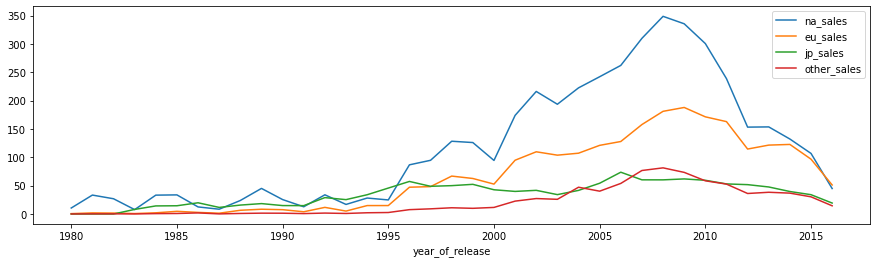

In [203]:
df.groupby('year_of_release')[['na_sales','eu_sales','jp_sales','other_sales']].sum().plot(figsize=(15,4));
plt.show();

- обращает на себя внимание значительное падение продаж по всем регионам
- рынок игр в Северной Америке, после падения, практически стал по объму сопоставим с рынком Европы

In [204]:
df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating',
       'total_sales'],
      dtype='object')

- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [52]:
rating = df[df['rating'].notna()]
rating

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
...,...,...,...,...,...,...,...,...,...,...,...,...
16697,Bust-A-Move 3000,GC,2003,Puzzle,0.01,0.00,0.00,0.00,53.0,NaN,E,0.01
16698,Mega Brain Boost,DS,2008,Puzzle,0.01,0.00,0.00,0.00,48.0,NaN,E,0.01
16702,STORM: Frontline Nation,PC,2011,Strategy,0.00,0.01,0.00,0.00,60.0,7.2,E10+,0.01
16704,Plushees,DS,2008,Simulation,0.01,0.00,0.00,0.00,NaN,NaN,E,0.01


In [53]:
na_rating = rating.loc[:,['na_sales','rating']]
eu_rating = rating.loc[:,['eu_sales','rating']]
jp_rating = rating.loc[:,['jp_sales','rating']]
os_rating = rating.loc[:,['other_sales','rating']]
na_rating

,na_sales,rating
0,41.36,E
2,15.68,E
3,15.61,E
6,11.28,E
7,13.96,E
...,...,...
16697,0.01,E
16698,0.01,E
16702,0.00,E10+
16704,0.01,E


<Figure size 216x216 with 0 Axes>

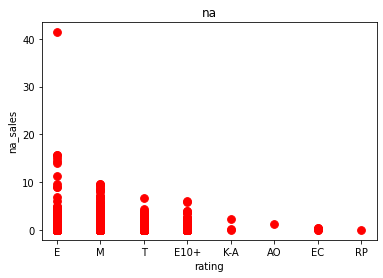

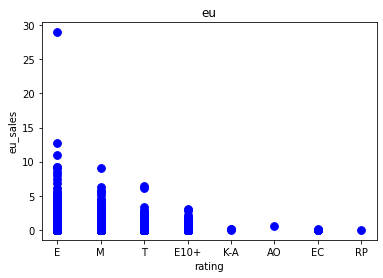

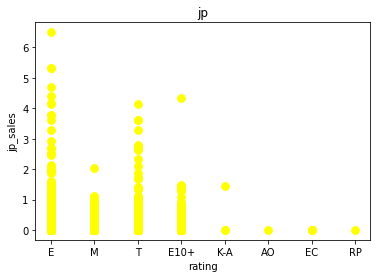

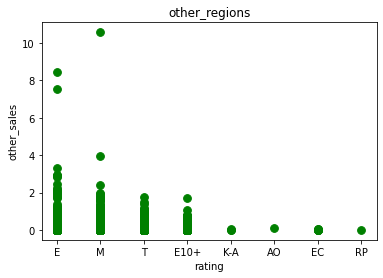

In [54]:
plt.figure(figsize=(3,3))
na_rating.plot.scatter('rating','na_sales', s=60, c='red')
plt.title('na')
eu_rating.plot.scatter('rating','eu_sales', s=60, c='blue')
plt.title('eu')
jp_rating.plot.scatter('rating','jp_sales', s=60, c='yellow')
plt.title('jp')
os_rating.plot.scatter('rating','other_sales', s=60, c='green')
plt.title('other_regions')
plt.show();

**Промежуточный вывод**
- прослеживается связь между рейтингом и продажами
- эта связь имеет место во всех регионах
- наибольшие продажи среди игр с рейтингом E, M, T
- среди с рейтингом RP, K-A, AO, EC нет высоких продаж

**График ниже не строится нормально. Пожалуйста, подскажите, где моя ошибка**)

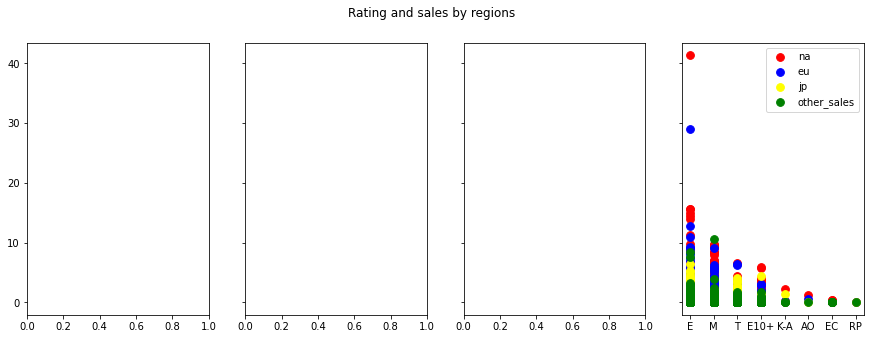

In [55]:
fig, axs = plt.subplots(1,4, figsize=(15,5), sharey=True)
axs[0] = plt.scatter(na_rating['rating'].values, na_rating['na_sales'].values, s=60, c='red', label='na')
axs[1] = plt.scatter(eu_rating['rating'].values, eu_rating['eu_sales'].values, s=60, c='blue', label='eu')
axs[2] = plt.scatter(jp_rating['rating'].values, jp_rating['jp_sales'].values, s=60, c='yellow',label='jp')
axs[3] = plt.scatter(os_rating['rating'].values, os_rating['other_sales'].values, s=60, c='green', label='other_sales')
plt.legend()
plt.suptitle('Rating and sales by regions')
plt.show()


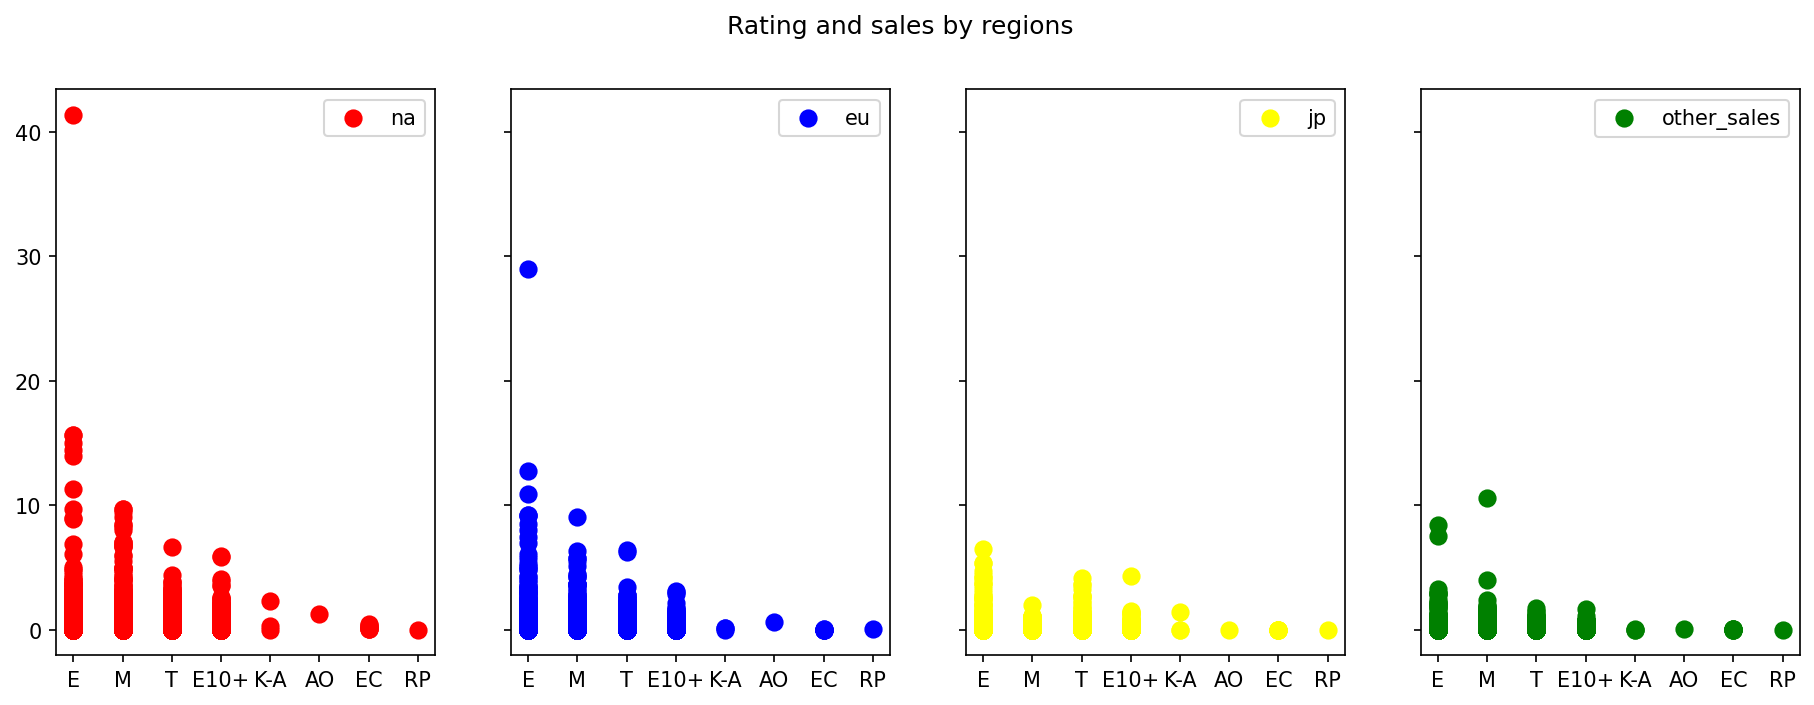

In [89]:
# Код ревьюера

fig, axs = plt.subplots(1,4, figsize=(15,5), sharey=True, dpi=150)
axs[0].scatter(na_rating['rating'].values, na_rating['na_sales'].values, s=60, c='red', label='na')
axs[1].scatter(eu_rating['rating'].values, eu_rating['eu_sales'].values, s=60, c='blue', label='eu')
axs[2].scatter(jp_rating['rating'].values, jp_rating['jp_sales'].values, s=60, c='yellow',label='jp')
axs[3].scatter(os_rating['rating'].values, os_rating['other_sales'].values, s=60, c='green', label='other_sales')

for ax in axs.flat:
    ax.legend()

plt.suptitle('Rating and sales by regions')
plt.show()

**Попробовал по другому, но нормально не отображается. Как исправить, подскажите.**
- хотелось сделать наглядную визуализацию -  все регины в один ряд

plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,4,1)
na_rating.plot.scatter('rating','na_sales', s=60, c='red')
plt.title('na')
ax2 = plt.subplot(1,4,2)
eu_rating.plot.scatter('rating','eu_sales', s=60, c='blue')
plt.title('eu')
ax3 = plt.subplot(1,4,3)
jp_rating.plot.scatter('rating','jp_sales', s=60, c='yellow')
plt.title('jp')
ax4 = plt.subplot(1,4,4)
os_rating.plot.scatter('rating','other_sales', s=60, c='green')
plt.title('other_sales')
plt.show()


**Шаг 5**

Проверьте гипотезы
- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
Задайте самостоятельно пороговое значение alpha.

Поясните:
- Как вы сформулировали нулевую и альтернативную гипотезы;
- Какой критерий применили для проверки гипотез и почему.

In [57]:
# находим средний пользовательский рейтинг для XOne
user_xbox = df[(df['platform'] == 'XOne') & (df['user_score'].notna())]['user_score']
user_xbox.mean()

6.521428

In [58]:
# находим средний рейтинг для РС
user_pc = df[(df['platform'] == 'PC') & (df['user_score'].notna())]['user_score']
user_pc.mean()

7.06596

In [59]:
# проверим гипотезу о равенстве срединх в этих двух выборках
# нулевая гипотеза - средние выборок равны
results = st.ttest_ind(user_xbox.values, user_pc)
alpha = 0.01
print('p value: ', format(results.pvalue, '.6f'))
if results.pvalue < alpha:
    print('Отличия между средними выборок достоверны')
else:
    print('Достоверный отличий между выборками нет')

p value:  0.000013
Отличия между средними выборок достоверны


In [60]:
user_action = df[(df['genre']=='Action') & (df['user_score'].notna())]['user_score']
user_sports = df[(df['genre']=='Sports') & (df['user_score'].notna())]['user_score']
print(f'Action mean: {user_action.mean()}\nSports mean: {user_sports.mean()}')
alpha = 0.01
result = st.ttest_ind(user_action.values, user_sports.values)
print('p value: ', round(result.pvalue, 4))
if result.pvalue < alpha:
    print('Отличия между средними выборок достоверны')
else:
    print('Достоверных отличий между средними выборок нет')

Action mean: 7.05812931060791
Sports mean: 6.9514336585998535
p value:  0.0648
Достоверных отличий между средними выборок нет


**Промежуточный вывод**
- нулевая гипотеза сформулирована так, что отличий между средними выборок нет
- имеются достоверные отличия между средними пользовательскими рейтингами между платформами XOne и PC
- пользовательские рейтинги жанров Sports и Action достоверно не различаются
- для проверки гипотез использовался метод ttest_ind, который предназначен для сравнения средних двух разных выборок.

## Общий вывод
**Проведен анализ данных продаж компьютерных игр в зависимости от следующих показателей:**
 - региона
 - игровой платформы
 - жанра
 - оценки пользователей
 - оценки экспертов
 - рейтинга

**В предствленном датасете выявлены следующие дефекты:**
- в 6 столбцах из одиннадцати имеются пропуски данных
- в столбце User_Score  и Years_of_release данные сохранены неверно, вместо float используется object
- До 2000 года отсутствует 90% и более данных в столбцах с оценками критиков, пользователей и рейтингу

**Причины появления пропусков**
- до 1984 года по-видимому, вообще эти данные не собирались, так как они полностью отсутствуют. Далее они начали изредка появляться. С течением времени объем собираемых данных по отзывам и рейтингам становится больше. Но судя по всему эти разделы не являются обязательными при сборе статистики, поэтому даже в лучшие периоды могло отсутствовать до 21% этой информации.

**Данные**
- В представленных данных содержится информация по 11559 играм, 12 жанрам, 31 платформе
- до 1994 года количество выпущенных игр очень мало по сравнению с другими периодами. Возможно, при дальнейшем анализе данные за этот период можно не рассматривать, учитывая,что в эти же периоды нет данных по оценкам и рейтингу


**Продажи**

- Наибольшие продажи исторически были в регионе Севрная Америка. В течении последних лет продажи во всех регионах упали, при этом продажи в Северной Америке стали примерно сопоставимы с продажами в Европе
- на последний отчетный период на рынке представлены девять платформ; две появились три года назад
- все платформы снизили продажи в 2016 году; можно ожидать,что в 2017 году с рынка уйдут две или даже три последнии платформы: Wii, X360, PS3; для задачи прогнозирования можно предположить, что первые три платформы останутся потенциально прибыльными: PS4, XOne, 3DS
- три лидирующие платформы имеют примерно одинаковый уровень средних продаж на игру, чуть ниже у 3DS; у платформы 3DS самый большой разброс продаж, у ней есть игры, которые являются лидерами по объему продаж среди этих платфрм; самый маленький разброс продаж по играм у платформы XOne
- оценить прибыльность жанров по имеющимся данным можно только, если продажи считать за прибыль, но это всегда объективно можно в качестве прибыльности взять продажи на одну игру в рамках жанра тогда  по уровню продажи лидерами являются жанры с Action, Sports, Shooter; отстающие жанры Strategy, Pazzle, Adventure
- средний срок появления новых платформ -  1.74 года, максимальный срок между появлением новых платформ -  5 лет, минимальнй срок между появлением новых платформ -  1 год

**Факторы, влиящие на продажи:**
   1. есть положительная средняя корреляция между уровнем продаж и оценкой критиков 
   2. практически нет корреляции между продажами и оценкой пользователей, она отрицательна с очень низким уровнем
   3. прослеживается связь между рейтингом и продажами; эта связь имеет место во всех регионах; наибольшие продажи среди       игр с рейтингом E, M, T; среди с игр рейтингом RP, K-A, AO, EC нет высоких продаж


**Пользователи**
- по предпочтениям платформ сильно отличается японский потребитель
- в остальных регионах в топ 5 входят четыре одинаковые платформы: PS2, PS3, X360, Wii
- по предпочитаемым жанрам во всех в тройку лидеров входят три жанра: Action, Sports, Misc
- три региона, кроме Японии имеют очень схожие предпочтения и одинаковый топ-3
- Европа и другие регионы имееют полностью совпадающий топ-5
- в Японии на первом месте находиться жанр Role-Playing, который вообще не вошел в топ-5 в других регионах
- имеются достоверные отличия между средними пользовательскими рейтингами между платформами XOne и PC;для проверки гипотез использовался метод ttest_ind, который предназначен для сравнения средних двух разных выборок.
- пользовательские рейтинги жанров Sports и Action достоверно не различаются
